In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras import Input, Model, layers, regularizers, callbacks
from keras.optimizers.legacy import Adam
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from scipy.stats import pearsonr
import utils_results as ut

In [2]:
basin = 'GLB'
n_clusters = 10
n_vars = 8
n_idxs = 9
results_folder = 'test2_linreg_nc10_nv8_nd9'
model_kind = 'linreg'
n_folds = 3
start_year = 1980
end_year = 2021

In [3]:
# Set project directory and name of file containing the target variable
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
target_file = 'target_1970-2022_2.5x2.5.csv'

# Retrieve the clusters type of data from the results folder
nc_string = results_folder.split('_')[2]
if "A" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_anomaly'
elif "DS" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
else:
    cluster_data = f'{basin}_{n_clusters}clusters'

# Set the paths to the files
experiment_filename = f'1970-2022_{n_clusters}clusters_{n_vars}vars_{n_idxs}idxs.csv'
sol_filename = f'{model_kind}_' + experiment_filename
predictor_file = 'predictors_' + experiment_filename
fs_dir = os.path.join(project_dir, 'FS_TCG')
output_dir = os.path.join(fs_dir, 'results', basin, results_folder)
sol_path = os.path.join(output_dir, sol_filename)
# final_sol_path = os.path.join(output_dir, f'CRO_{sol_filename}')
best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
data_dir = os.path.join(fs_dir, 'data', cluster_data)
predictors_path = os.path.join(data_dir, predictor_file)
target_path = os.path.join(data_dir, target_file)
gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')

In [4]:
# Load the predictors and the target in a DataFrame
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)
if "DS" in nc_string:
    target_season_df = pd.read_csv(os.path.join(data_dir, target_season), index_col=0)
    target_season_df.index = pd.to_datetime(target_season_df.index)

# Load the gpis time series dataframe and select the target GPIs for physical information to pass to the network
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpi_pi = gpis_df['ogpi']

# Load the solutions file in a DataFrame and the best solution found
sol_file_df = pd.read_csv(sol_path, sep=' ', header=0)
best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
best_solution = best_solution.to_numpy().flatten()

In [5]:
# Select the variables from the best solutions and plot it
column_names = predictors_df.columns.tolist()
final_sequence = best_solution[len(column_names):2*len(column_names)]
sequence_length = best_solution[:len(column_names)]
feat_sel = best_solution[2*len(column_names):]
n_rows = len(column_names)
n_cols = int(((sequence_length + final_sequence)*feat_sel).max())

# Create dataset according to solution and list the labels of the selected variables
variable_selection = feat_sel.astype(int)
time_sequences = sequence_length.astype(int)
time_lags = final_sequence.astype(int)
label_selected_vars = []
dataset_opt = target_df.copy()
for c, col in enumerate(predictors_df.columns):
    if variable_selection[c] == 0 or time_sequences[c] == 0:
        continue
    for j in range(time_sequences[c]):
        dataset_opt[str(col) +'_lag'+ str(time_lags[c]+j)] = predictors_df[col].shift(time_lags[c]+j)
        label_selected_vars.append(str(col) +'_lag'+ str(time_lags[c]+j))

In [6]:
# Compone the dataset to train the model using all predictors possible
dataset_opt_noFS = target_df.copy()
for l in range(1):
    for var in predictors_df.columns:
        col_df = pd.DataFrame(predictors_df[var].shift(l).values, index=dataset_opt_noFS.index, columns=[f'{var}_lag{l}'])
        dataset_opt_noFS = pd.concat([dataset_opt_noFS, col_df], axis=1)

In [10]:
test_mse1 = []
test_mse2 = []
test_mse3 = []
test_mse_tot = []
r_tot = []

for n_exp in range(100):
    ## Train MLPregressor with the best solution found ##
    # Cross-Validation for train and test years
    years = np.arange(start_year, end_year+1, 1)
    kfold = KFold(n_splits=n_folds)
    Y_column = 'tcg' # Target variable
    obs_indices = dataset_opt.index.year.isin(years)
    obs_dataset = dataset_opt[obs_indices]
    Y_test = obs_dataset[Y_column]
    Y_pred_mlp = pd.DataFrame()
    # Y_pred_mlp_noFS = pd.DataFrame()
    # Y_pred_lgbm = pd.DataFrame()
    # Y_pred_pi_lgbm = pd.DataFrame()
    # Y_pred_lgbm_noFS = pd.DataFrame()
    # Y_pred_pi_lgbm_noFS = pd.DataFrame()

    for n_fold, (train_index, test_index) in enumerate(kfold.split(years)):

        # Set the indices for the training and test datasets
        train_years = years[train_index]
        test_years = years[test_index]
        # Split the optimized dataset
        train_indices = dataset_opt.index.year.isin(train_years)
        test_indices = dataset_opt.index.year.isin(test_years)
        train_dataset = dataset_opt[train_indices]
        test_dataset = dataset_opt[test_indices]
        # Split the entire dataset 
        train_indices_noFS = dataset_opt_noFS.index.year.isin(train_years)
        test_indices_noFS = dataset_opt_noFS.index.year.isin(test_years)
        train_dataset_noFS = dataset_opt_noFS[train_indices_noFS]
        test_dataset_noFS = dataset_opt_noFS[test_indices_noFS]
        # Split the gpis dataset
        gpi_pi_train = gpi_pi[train_indices]
        gpi_pi_test = gpi_pi[test_indices]

        # Standardize the optimized dataset
        X_train = train_dataset[train_dataset.columns.drop([Y_column])]
        Y_train = train_dataset[Y_column]
        X_test_fold = test_dataset[test_dataset.columns.drop([Y_column])]
        Y_test_fold = test_dataset[Y_column]
        scaler = preprocessing.MinMaxScaler()
        X_std_train = scaler.fit(X_train)
        X_std_train = scaler.transform(X_train)
        X_std_test = scaler.transform(X_test_fold)
        X_train = pd.DataFrame(X_std_train, columns=X_train.columns, index=X_train.index)
        X_test = pd.DataFrame(X_std_test, columns=X_test_fold.columns, index=X_test_fold.index)
        # Standardize the entire dataset
        X_train_noFS = train_dataset_noFS[train_dataset_noFS.columns.drop([Y_column])]
        X_test_fold_noFS = test_dataset_noFS[test_dataset_noFS.columns.drop([Y_column])]
        scaler_noFS = preprocessing.MinMaxScaler()
        X_std_train_noFS = scaler_noFS.fit(X_train_noFS)
        X_std_train_noFS = scaler_noFS.transform(X_train_noFS)
        X_std_test_noFS = scaler_noFS.transform(X_test_fold_noFS)
        X_train_noFS = pd.DataFrame(X_std_train_noFS, columns=X_train_noFS.columns, index=X_train_noFS.index)
        X_test_noFS = pd.DataFrame(X_std_test_noFS, columns=X_test_fold_noFS.columns, index=X_test_fold_noFS.index)

        # Split the training set in training and validation sets for all models and both datasets
        X_t, X_v, Y_t, Y_v, X_t_noFS, X_v_noFS, gpi_pi_t, gpi_pi_v = train_test_split(X_train, Y_train, X_train_noFS, gpi_pi_train, test_size=0.2, random_state=42)

        ## Define common training parameters and callbacks for the mlp ##
        n_neurons = 64
        epo = 100 # Number of epochs
        lr = 0.001 # Learning rate
        l2_reg = 0.001
        batch_size = 32
        callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        ## MLPregressor with Selected Features ##
        # Build and compile the multi layer perceptron model for the optimized dataset
        n_predictors = len(X_train.columns)
        inputs = Input(shape=(n_predictors,))
        x = layers.Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
        output = layers.Dense(1)(x)
        mlpreg = Model(inputs, output)
        mlpreg.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        # Prepare training and validation datasets
        train_data = tf.data.Dataset.from_tensor_slices((X_t.values, Y_t.values)).batch(batch_size)
        val_data = tf.data.Dataset.from_tensor_slices((X_v.values, Y_v.values)).batch(batch_size)
        # Train the model
        history = mlpreg.fit(train_data, validation_data=val_data, epochs=epo, callbacks=[callback], verbose=0)
        # Evaluate the model
        Y_pred_fold = mlpreg.predict(X_test, verbose=0)
        Y_pred_fold = pd.DataFrame(Y_pred_fold, index=Y_test_fold.index, columns=['tcg'])
        Y_pred_mlp = pd.concat([Y_pred_mlp, Y_pred_fold])
        loss = mlpreg.evaluate(X_test, Y_test_fold, verbose=0)

        if n_fold == 0:
            test_mse1.append(loss)
        elif n_fold == 1:
            test_mse2.append(loss)
        elif n_fold == 2:
            test_mse3.append(loss)

        ## MLPregressor with all Features ##
        # Build and compile the multi layer perceptron model for the entire dataset
        # n_predictors_noFS = len(X_train_noFS.columns)
        # inputs = Input(shape=(n_predictors_noFS,))
        # x = layers.Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
        # output = layers.Dense(1)(x)
        # mlpreg_noFS = Model(inputs, output)
        # mlpreg_noFS.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        # # Prepare training and validation datasets
        # train_data = tf.data.Dataset.from_tensor_slices((X_t_noFS.values, Y_t.values)).batch(batch_size)
        # val_data = tf.data.Dataset.from_tensor_slices((X_v_noFS.values, Y_v.values)).batch(batch_size)
        # # Train the model
        # history_noFS = mlpreg_noFS.fit(train_data, validation_data=val_data, epochs=epo, callbacks=[callback], verbose=0)
        # # Evaluate the model
        # Y_pred_fold_noFS = mlpreg_noFS.predict(X_test_noFS, verbose=0)
        # Y_pred_fold_noFS = pd.DataFrame(Y_pred_fold_noFS, index=Y_test_fold.index, columns=['tcg'])
        # Y_pred_mlp_noFS = pd.concat([Y_pred_mlp_noFS, Y_pred_fold_noFS])
        # loss_noFS = mlpreg_noFS.evaluate(X_test_noFS, Y_test_fold, verbose=0)
        # fig = plt.figure(figsize=(10, 6))
        # ax = fig.add_subplot(1, 1, 1)
        # ax.plot(history.history['loss'], label='FS loss', color='#1f77b4')
        # ax.plot(history.history['val_loss'], label='FS val loss', color='#ff7f0e')
        # ax.plot(history_noFS.history['loss'], label='NoFS loss', color='#1f77b4', linestyle='--')
        # ax.plot(history_noFS.history['val_loss'], label='NoFS val loss', color='#ff7f0e', linestyle='--')
        # ax.axhline(y=loss, color='#2ca02c', linestyle=':', label='Test loss')
        # ax.axhline(y=loss_noFS, color='#d62728', linestyle=':', label='NoFS Test loss')
        # ax.set_xlabel('Epochs')
        # ax.set_ylabel('Loss')
        # ax.legend()
        # plt.tight_layout()
        # plt.show()

    ## Time series plots ##
    # Load the engpi and the ogpi time series 
    df_gpis = pd.read_csv(os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv'), index_col=0)
    df_gpis.index = pd.to_datetime(df_gpis.index)
    df_gpis = df_gpis.loc[f'{test_years[0]}':f'{test_years[-1]}']
    engpi = df_gpis['engpi']
    ogpi = df_gpis['ogpi']
    # Compute seasonal mean values and annual cumulative values
    Y_pred = Y_pred_mlp
    test_tot = mean_squared_error(Y_test, Y_pred)
    Y_pred_annual = Y_pred.groupby(Y_pred.index.year).sum()
    Y_test_annual = Y_test.groupby(Y_test.index.year).sum()
    engpi_annual = engpi.groupby(engpi.index.year).sum()
    ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
    # Correlation coefficients
    r, _ = pearsonr(Y_test, Y_pred['tcg'])
    # r_engpi, _ = pearsonr(Y_test['tcg'], engpi)
    # r_ogpi, _ = pearsonr(Y_test['tcg'], ogpi)
    rY, _ = pearsonr(Y_test_annual, Y_pred_annual['tcg'])
    # r_engpiY, _ = pearsonr(Y_test_annual['tcg'], engpi_annual)
    # r_ogpiY, _ = pearsonr(Y_test_annual['tcg'], ogpi_annual)

    test_mse_tot.append(test_tot)
    r_tot.append(rY)

    print(f'{n_exp+1:03d} - MSE: {test_tot:.3f} - R:{rY:.3f}')

001 - MSE: 5.351 - R:0.478
002 - MSE: 5.235 - R:0.505
003 - MSE: 5.307 - R:0.506
004 - MSE: 5.215 - R:0.505
005 - MSE: 5.202 - R:0.514
006 - MSE: 5.144 - R:0.482
007 - MSE: 5.180 - R:0.500
008 - MSE: 5.175 - R:0.522
009 - MSE: 5.297 - R:0.513
010 - MSE: 5.216 - R:0.502
011 - MSE: 5.225 - R:0.516
012 - MSE: 5.202 - R:0.517
013 - MSE: 5.221 - R:0.538
014 - MSE: 5.165 - R:0.520
015 - MSE: 5.284 - R:0.497
016 - MSE: 5.136 - R:0.529
017 - MSE: 5.193 - R:0.502
018 - MSE: 5.235 - R:0.486
019 - MSE: 5.160 - R:0.491
020 - MSE: 5.159 - R:0.496
021 - MSE: 5.203 - R:0.471
022 - MSE: 5.255 - R:0.515
023 - MSE: 5.245 - R:0.532
024 - MSE: 5.234 - R:0.519
025 - MSE: 5.197 - R:0.515
026 - MSE: 5.203 - R:0.507
027 - MSE: 5.256 - R:0.517
028 - MSE: 5.308 - R:0.486
029 - MSE: 5.215 - R:0.499
030 - MSE: 5.217 - R:0.505
031 - MSE: 5.292 - R:0.494
032 - MSE: 5.194 - R:0.528
033 - MSE: 5.156 - R:0.476
034 - MSE: 5.303 - R:0.508
035 - MSE: 5.120 - R:0.515
036 - MSE: 5.223 - R:0.500
037 - MSE: 5.179 - R:0.495
0

In [22]:
import numpy as np

def coefficient_of_variation(data):
    return np.std(data) / np.mean(data)

cv1 = coefficient_of_variation(test_mse_tot)
cv2 = coefficient_of_variation(r_tot)

print(f"CV of Dataset 1: {cv1:.4f}")
print(f"CV of Dataset 2: {cv2:.4f}")

CV of Dataset 1: 0.0111
CV of Dataset 2: 0.0392


In [23]:
from sklearn.preprocessing import StandardScaler

test_mse_tot = np.array(test_mse_tot)
r_tot = np.array(r_tot)

scaler = StandardScaler()
mse_scaled = scaler.fit_transform(test_mse_tot.reshape(-1, 1))
r_scaled = scaler.fit_transform(r_tot.reshape(-1, 1))

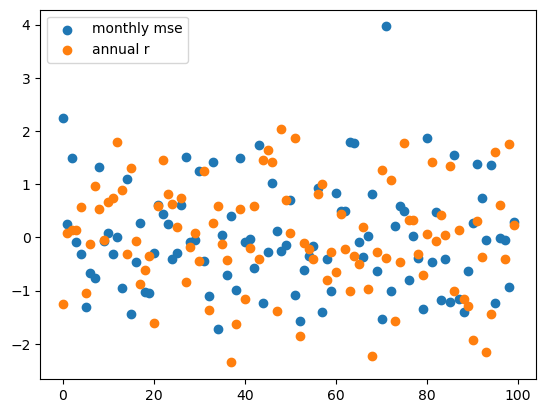

In [24]:
plt.figure()
plt.scatter(np.arange(len(mse_scaled)), mse_scaled, label='monthly mse')
plt.scatter(np.arange(len(mse_scaled)), r_scaled, label='annual r')
plt.legend(loc='upper left')
plt.show()